<a href="https://colab.research.google.com/github/matthiasweidlich/conf_tutorial/blob/master/alignment_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hands-On Exercise 3: Alignment-based Conformance

In this exercise, we will again take up the real-life event log of a Dutch financial institute. Be reminded that you should be able to clone the repository containing the notebooks and the example data with the code in the next cell. If this does not work, however, you can also download the event log (XES format, please unzip) [here](http://www.win.tue.nl/bpi/doku.php?id=2012:challenge) and then either copy it to your google drive, mount it, and read it from there, or directly upload it using your browser.

Also, further details can be found in the [description of the dataset](http://www.win.tue.nl/bpi/doku.php?id=2012:challenge).

In [1]:
# basic configuration
%config InlineBackend.figure_format = 'svg'
%matplotlib inline

# import data from google drive
#from google.colab import drive
#drive.mount('/content/drive')

# direct data upload
#from google.colab import files
#files.upload()

# clone the repository that contains the notebooks and also the data file
! git clone https://github.com/matthiasweidlich/conf_tutorial.git

Cloning into 'conf_tutorial'...
remote: Enumerating objects: 103, done.
remote: Counting objects: 100% (103/103), done.
remote: Compressing objects: 100% (90/90), done.
remote: Total 103 (delta 56), reused 31 (delta 11), pack-reused 0
Receiving objects: 100% (103/103), 3.36 MiB | 5.87 MiB/s, done.
Resolving deltas: 100% (56/56), done.


## Import Event Log
The following method imports the log file and returns it in a list structure.

In [0]:
import xml.etree.ElementTree as et

def load_xes(file, event_filter = []):
    log = []
    
    tree = et.parse(file)
    data = tree.getroot()
    
    # find all traces
    traces = data.findall('{http://www.xes-standard.org/}trace')
    
    for t in traces:
        trace_id = None
        
        # get trace id
        for a in t.findall('{http://www.xes-standard.org/}string'):
            if a.attrib['key'] == 'concept:name':
                trace_id = a.attrib['value']
        
        events = []
        # events
        for event in t.iter('{http://www.xes-standard.org/}event'):
            
            e = {'name': None, 'timestamp': None, 'resource': None, 'transition': None}
            
            for a in event:
                e[a.attrib['key'].split(':')[1]] = a.attrib['value']
            
            if e['name'] in event_filter or len(event_filter) == 0:
                events.append(e)
        
        # add trace to log
        if len(events) > 0:
            log.append({'trace_id': trace_id, 'events': events})
        
    return log

Now import the given log and compute the trace variants of the log along with their frequencies.

In [3]:
from pprint import pprint

log_file = 'conf_tutorial/financial_log.xes'
log = load_xes(log_file)

print('Load log with %s traces.' %len(log))

trace_variants = {}
for trace in log:
    events = []
    for event in trace['events']:
        events.append(event['name'])
    trace_variants[tuple(events)] = trace_variants.get(tuple(events), 0) + 1
    
# print the two most frequent variants
trace_variants_sorted_by_freq = sorted(trace_variants.items(), key=lambda kv: kv[1], reverse=True)
pprint(trace_variants_sorted_by_freq[:2])

Load log with 13087 traces.
[(('A_SUBMITTED', 'A_PARTLYSUBMITTED', 'A_DECLINED'), 3429),
 (('A_SUBMITTED',
   'A_PARTLYSUBMITTED',
   'W_Afhandelen leads',
   'W_Afhandelen leads',
   'A_DECLINED',
   'W_Afhandelen leads'),
  1872)]


## Import Process Model

For the log, a process model is given in the form of a Petri net. Such a process model is typically created manually. For this particular example, however, the model has been discovered automatically using the Inductive Miner, applying some noise filtering threshold. 

Note that here, we relabel the silent transitions (label *tau*) so that all transitions are uniquely labelled (e.g., *tau* becomes *tau-x* with x being an id). This is purely a technical consideration as it is required by the code used later.

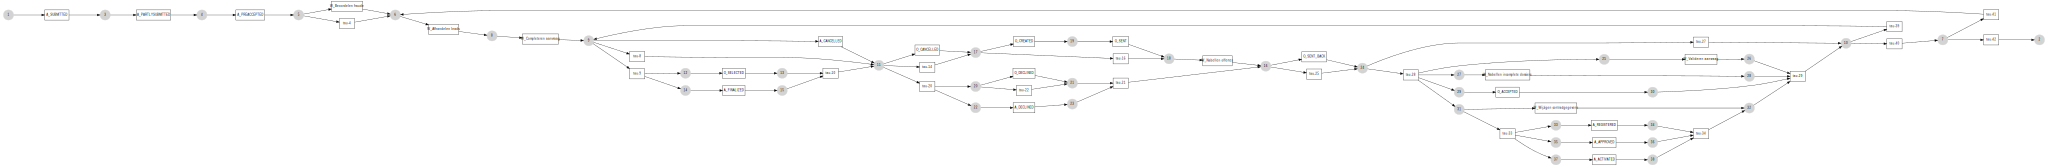

In [4]:
%run ./conf_tutorial/pn.py

net = PetriNet()
load(net, "./conf_tutorial/financial_log_80_noise.pnml")

# mark the initial place
net.add_marking(1,1)

# make sure to assign unique labels to silent transitions
t_transitions = dict()
for t in net.transitions['tau']:
    net.transitions['tau' + str(t)] = [t]
net.transitions.pop('tau', None)


# visualise it 
draw_petri_net(net)

## Alignment Construction

To assess the conformance of the traces of the log with the process model, we next compute optimal alignments between them. To this end, an implementation of the alignment construction based on A* search is used. 

Traces of the same trace variant have equal sets of optimal alignments. We therefore consider the construction of alignments solely for trace variants. The code below computes optimal alignments for the most frequent trace variants.



In [5]:
%run ./conf_tutorial/alignment.py

# select some most frequent traces
traces = dict()
for k in range(10):
    traces[k] = list(trace_variants_sorted_by_freq[k][0])

# capture details on which places denote the start and the end of the process model
index_place_start = 0
index_place_end = 1

# run alignment construction
a = Astar()
alignments = a.Astar_Exe(net, traces, index_place_start, index_place_end, no_of_solutions=1)


100%|██████████| 10/10 [00:02<00:00,  3.22it/s]


Now, let us have a look at the computed alignments:

In [12]:
for k,t in traces.items():
  print('Trace in the log: ', t)
  print('Optimal alignment: ')
  pprint(alignments[k][0])

Trace in the log:  ['A_SUBMITTED', 'A_PARTLYSUBMITTED', 'A_DECLINED']
Optimal alignment: 
[('A_SUBMITTED', 'A_SUBMITTED'),
 ('A_PARTLYSUBMITTED', 'A_PARTLYSUBMITTED'),
 ('A_DECLINED', '-'),
 ('-', 'A_PREACCEPTED'),
 ('-', 'W_Afhandelen leads'),
 ('-', 'W_Completeren aanvraag'),
 ('-', 'W_Nabellen offertes')]
Trace in the log:  ['A_SUBMITTED', 'A_PARTLYSUBMITTED', 'W_Afhandelen leads', 'W_Afhandelen leads', 'A_DECLINED', 'W_Afhandelen leads']
Optimal alignment: 
[('A_SUBMITTED', 'A_SUBMITTED'),
 ('A_PARTLYSUBMITTED', 'A_PARTLYSUBMITTED'),
 ('W_Afhandelen leads', '-'),
 ('W_Afhandelen leads', '-'),
 ('A_DECLINED', '-'),
 ('-', 'A_PREACCEPTED'),
 ('W_Afhandelen leads', 'W_Afhandelen leads'),
 ('-', 'W_Completeren aanvraag'),
 ('-', 'W_Nabellen offertes')]
Trace in the log:  ['A_SUBMITTED', 'A_PARTLYSUBMITTED', 'W_Afhandelen leads', 'W_Afhandelen leads', 'W_Afhandelen leads', 'W_Afhandelen leads', 'A_DECLINED', 'W_Afhandelen leads']
Optimal alignment: 
[('A_SUBMITTED', 'A_SUBMITTED'),
 ('A

Next, consider the fitness of the most frequent trace variants.

**Task:** Complete the function for the fitness computation. Note that the length of the shortest firing sequence in the imported Petri net is given.

In [0]:
def fitness(net: PetriNet, alignments: list, log_freq: list) -> float:
    shortest_seq_in_net = 7
    
    async_moves = 0
    max_cost = 0
    
    for k in range(len(alignments)):
        async_moves += log_freq[k] * len([x for x in alignments[k] if (x[0] == '-' or x[1] == '-')])    
        max_cost += log_freq[k] * (shortest_seq_in_net + len(alignments[k]))
      
    return round(float(async_moves) / float(max_cost), 3)

Now, see how the fitness value changes when considering the most frequent trace variants.

In [51]:
fitness_value = 0
for k in range(len(alignments)):
    alignments_simple_k = [alignments[k][0]]
    alignments_simple = [alignments[x][0] for x in range(k+1)]
    log_freq_k = [trace_variants_sorted_by_freq[k][1]]
    log_freq = [trace_variants_sorted_by_freq[x][1] for x in range(k+1)]
    fitness_value_k = fitness(net, alignments_simple_k, log_freq_k)
    fitness_value = fitness(net, alignments_simple, log_freq)
    print("Fitness value of the single %s-most frequent trace variant: %f" % (k+1, fitness_value_k))
    print("Fitness value of %s-most frequent trace variants: %f" % (k+1, fitness_value))



Fitness value of the single 1-most frequent trace variant: 0.357000
Fitness value of 1-most frequent trace variants: 0.357000
Fitness value of the single 2-most frequent trace variant: 0.375000
Fitness value of 2-most frequent trace variants: 0.364000
Fitness value of the single 3-most frequent trace variant: 0.444000
Fitness value of 3-most frequent trace variants: 0.369000
Fitness value of the single 4-most frequent trace variant: 0.235000
Fitness value of 4-most frequent trace variants: 0.363000
Fitness value of the single 5-most frequent trace variant: 0.312000
Fitness value of 5-most frequent trace variants: 0.362000
Fitness value of the single 6-most frequent trace variant: 0.312000
Fitness value of 6-most frequent trace variants: 0.361000
Fitness value of the single 7-most frequent trace variant: 0.316000
Fitness value of 7-most frequent trace variants: 0.359000
Fitness value of the single 8-most frequent trace variant: 0.389000
Fitness value of 8-most frequent trace variants: 0

Finally, plot some frequent deviations, i.e., activities that often occur in asynchronous moves in the alignments.

**Task:** Derive the deviation distribution over the activities, i.e., the distribution of the frequency with which the activities participate in deviations.

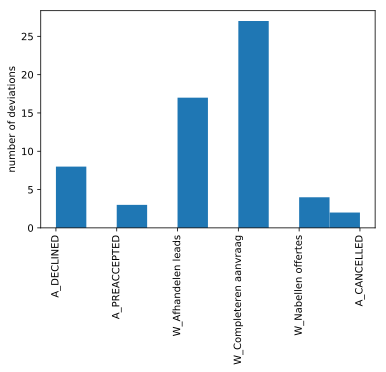

In [60]:
import matplotlib.pyplot as plt

deviations = []

for alignment in alignments.values():
    deviations.extend([x[0] for x in alignment[0] if x[1] == '-'])
    deviations.extend([x[1] for x in alignment[0] if x[0] == '-'])

plt.hist(deviations)
plt.xticks(rotation='vertical')
plt.ylabel('number of deviations')
plt.show()

## -- End